In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
df = pd.read_csv("azurefunctions-accesses-2020.csv.bz2")

Convert timestamp to datetime

In [3]:
df["Datetime"] = pd.to_datetime(df["Timestamp"], unit='ms')
df = df.sort_values(by="Datetime").reset_index(drop=True)

In [4]:
cat_columns = df.select_dtypes(['object']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0])

In [5]:
df['hour'] = df['Datetime'].dt.hour


In [6]:
sf = df.drop(['Timestamp','AnonUserId','AnonAppName','AnonFunctionInvocationId','AnonBlobName','AnonBlobETag','Datetime'], axis=1)
sf

,AnonRegion,BlobType,BlobBytes,Read,Write,hour
0,0,0,3662.0,True,False,0
1,0,0,17.0,True,False,0
2,1,1,63.0,False,True,0
3,2,0,22.0,True,False,0
4,0,0,17.0,False,True,0
...,...,...,...,...,...,...
44282907,1,3,185717.0,True,False,23
44282908,0,2,1392.0,True,False,23
44282909,0,2,121558.0,True,False,23
44282910,0,0,1358.0,True,False,23


In [7]:
sf["Read"] = sf["Read"].astype(int)
sf["Write"] = sf["Write"].astype(int)

In [9]:
indexNames = sf[(sf['AnonRegion'] == 27)|(sf['AnonRegion'] == 21)|(sf['AnonRegion'] == 26)|(sf['AnonRegion'] == 17)|(sf['AnonRegion'] == 25)|(sf['AnonRegion'] == 13) ].index
sf1 = sf.drop(indexNames , inplace=True)
sf1

In [10]:
sf1 = sf[df.AnonRegion.notnull()]
sf1['AnonRegion'].value_counts()

/tmp/ipykernel_435160/2973163739.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sf1 = sf[df.AnonRegion.notnull()]


14    13223956
20     9310584
1      8599315
0      6251268
10     2526394
16     1971532
3       681309
2       531489
7       366004
8       185525
11      150495
5       131439
6       113756
24       79808
9        52970
22       47214
4        31162
19       11581
12        7987
15        3938
18        3498
23         998
Name: AnonRegion, dtype: int64

<AxesSubplot: ylabel='Region'>

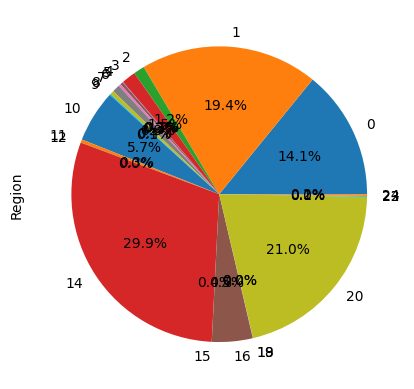

In [11]:
sf1.groupby('AnonRegion').size().plot(kind='pie',
                                       y = "v1",
                                       label = "Region",
                                       autopct='%1.1f%%')

In [12]:
min_sample = sf1[sf1["AnonRegion"] == 23]
need_to_resample = sf1['AnonRegion'].value_counts()
index_value = need_to_resample.index.tolist()

In [13]:
sample_data = sf1[sf1['AnonRegion'] == 23]
other_data = sf1[sf1['AnonRegion'] != 23]

In [36]:
sample_data['AnonRegion'].value_counts()

23    998
Name: AnonRegion, dtype: int64

In [60]:
#upsample the minority class
other_data_values = other_data['AnonRegion'].value_counts()
other_index_value = other_data_values.index.tolist()
other_index_value

[14, 20, 1, 0, 10, 16, 3, 2, 7, 8, 11, 5, 6, 24, 9, 22, 4, 19, 12, 15, 18]

In [121]:
from sklearn.utils import resample
data_downsampled = sample_data
sampled = []
for l in other_index_value:
    new_sampled = resample(sf1[sf1['AnonRegion'] == l],
             replace=True,
             n_samples=len(sample_data),
             random_state=42)
    data_downsampled = pd.concat([data_downsampled, new_sampled])

In [122]:
data_downsampled['AnonRegion'].value_counts()

23    998
14    998
15    998
12    998
19    998
4     998
22    998
9     998
24    998
6     998
5     998
11    998
8     998
7     998
2     998
3     998
16    998
10    998
0     998
1     998
20    998
18    998
Name: AnonRegion, dtype: int64

<AxesSubplot: ylabel='Region'>

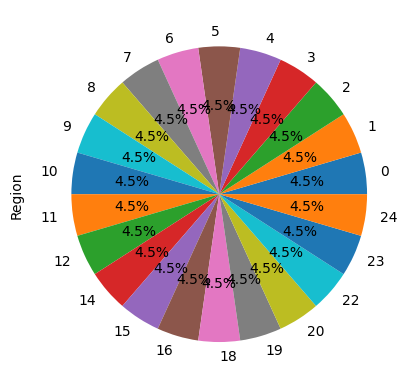

In [123]:
data_downsampled.groupby('AnonRegion').size().plot(kind='pie',
                                       y = "v1",
                                       label = "Region",
                                       autopct='%1.1f%%')

In [124]:
data_downsampled

,AnonRegion,BlobType,BlobBytes,Read,Write,hour
882043,23,7,126707.0,1,0,12
884168,23,7,125447.0,1,0,12
890533,23,7,252147.0,1,0,12
1057049,23,7,373.0,1,0,14
1075211,23,7,373.0,1,0,14
...,...,...,...,...,...,...
21511734,18,1,111591.0,0,1,14
16855431,18,1,73116.0,0,1,8
17447455,18,1,98514.0,0,1,12
7871825,18,1,987.0,0,1,15


In [125]:
data_downsampled.isnull().sum()

AnonRegion    0
BlobType      0
BlobBytes     0
Read          0
Write         0
hour          0
dtype: int64

In [126]:
#Reset index
data_downsampled = data_downsampled.reset_index(drop=True)

In [127]:
data_downsampled.loc[data_downsampled["hour"] < 12, "hour"] = 0
data_downsampled.loc[data_downsampled["hour"] >= 12, "hour"] = 1
data_downsampled

,AnonRegion,BlobType,BlobBytes,Read,Write,hour
0,23,7,126707.0,1,0,1
1,23,7,125447.0,1,0,1
2,23,7,252147.0,1,0,1
3,23,7,373.0,1,0,1
4,23,7,373.0,1,0,1
...,...,...,...,...,...,...
21951,18,1,111591.0,0,1,1
21952,18,1,73116.0,0,1,0
21953,18,1,98514.0,0,1,1
21954,18,1,987.0,0,1,1


In [128]:
data_downsampled['hour'].value_counts()

1    11821
0    10135
Name: hour, dtype: int64

In [129]:
temp = data_downsampled
temp

,AnonRegion,BlobType,BlobBytes,Read,Write,hour
0,23,7,126707.0,1,0,1
1,23,7,125447.0,1,0,1
2,23,7,252147.0,1,0,1
3,23,7,373.0,1,0,1
4,23,7,373.0,1,0,1
...,...,...,...,...,...,...
21951,18,1,111591.0,0,1,1
21952,18,1,73116.0,0,1,0
21953,18,1,98514.0,0,1,1
21954,18,1,987.0,0,1,1


In [131]:
temp['BlobBytes'].describe(include='all')

count    2.195600e+04
mean     2.619915e+05
std      4.321567e+06
min      0.000000e+00
25%      3.120000e+02
50%      1.968500e+03
75%      1.032700e+04
max      4.511078e+08
Name: BlobBytes, dtype: float64

In [132]:
def updateSizeValue(x):
    if x < 12500:
        return 0
    elif x < 125000:
        return 1
    elif x < 125000000:
        return 2
    else:
        return 3

In [133]:
temp['BlobBytes'] = temp['BlobBytes'].apply(updateSizeValue)
temp

,AnonRegion,BlobType,BlobBytes,Read,Write,hour
0,23,7,2,1,0,1
1,23,7,2,1,0,1
2,23,7,2,1,0,1
3,23,7,0,1,0,1
4,23,7,0,1,0,1
...,...,...,...,...,...,...
21951,18,1,1,0,1,1
21952,18,1,1,0,1,0
21953,18,1,1,0,1,1
21954,18,1,0,0,1,1


In [134]:
temp['BlobBytes'].value_counts()

0    17054
2     2596
1     2302
3        4
Name: BlobBytes, dtype: int64

In [73]:
temp

,AnonRegion,BlobType,BlobBytes,Read,Write,hour
0,23,7,2,1,0,1
1,23,7,2,1,0,1
2,23,7,2,1,0,1
3,23,7,0,1,0,1
4,23,7,0,1,0,1
...,...,...,...,...,...,...
21951,18,1,1,0,1,1
21952,18,1,1,0,1,0
21953,18,1,1,0,1,1
21954,18,1,0,0,1,1


In [137]:
from sklearn.cluster import AgglomerativeClustering 

agglom = AgglomerativeClustering(n_clusters=2, linkage='average').fit(temp)

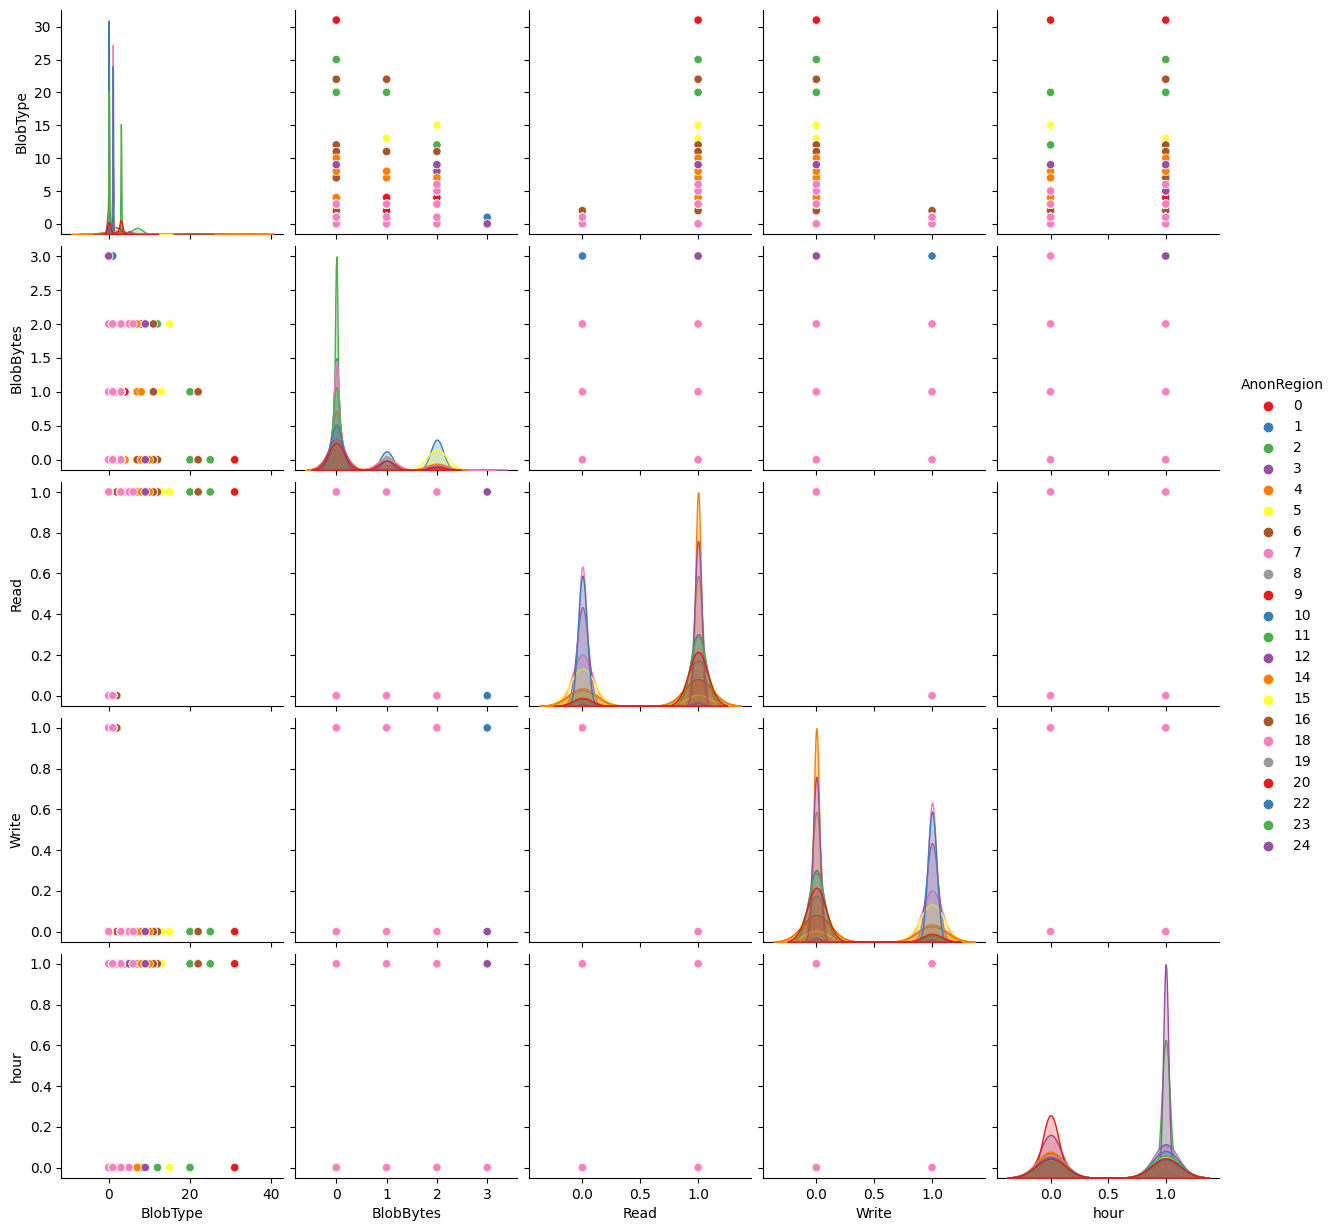

In [142]:
import seaborn as sns
sns.pairplot(data=temp,hue="AnonRegion",palette="Set1")
plt.show()

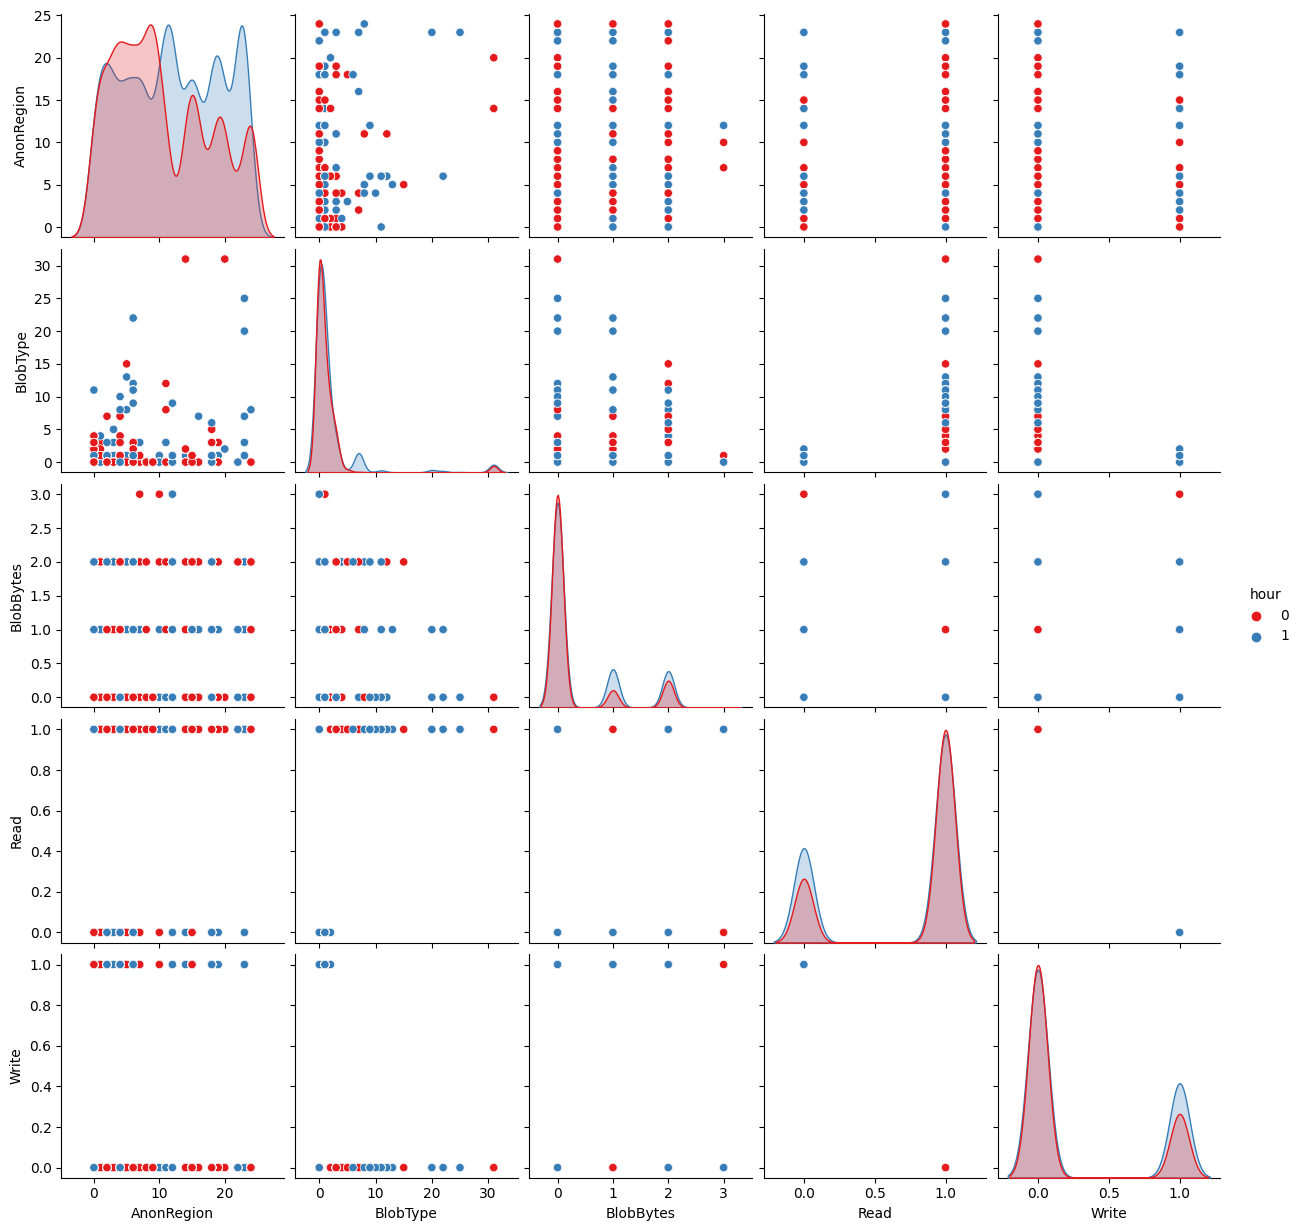

In [87]:
import seaborn as sns
sns.pairplot(data=temp,hue="hour",palette="Set1")
plt.show()

In [143]:
temp

,AnonRegion,BlobType,BlobBytes,Read,Write,hour
0,23,7,2,1,0,1
1,23,7,2,1,0,1
2,23,7,2,1,0,1
3,23,7,0,1,0,1
4,23,7,0,1,0,1
...,...,...,...,...,...,...
21951,18,1,1,0,1,1
21952,18,1,1,0,1,0
21953,18,1,1,0,1,1
21954,18,1,0,0,1,1


In [149]:
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler

ms = MinMaxScaler()
X = ms.fit_transform(X)
dfx = pd.DataFrame(data=X,columns=['BlobType','BlobBytes','Read','Write','hour'])
dfx.head()

,BlobType,BlobBytes,Read,Write,hour
0,0.225806,0.666667,1.0,0.0,1.0
1,0.225806,0.666667,1.0,0.0,1.0
2,0.225806,0.666667,1.0,0.0,1.0
3,0.225806,0.000000,1.0,0.0,1.0
4,0.225806,0.000000,1.0,0.0,1.0


In [150]:
dfx.describe()

,BlobType,BlobBytes,Read,Write,hour
count,21956.000000,21956.000000,21956.000000,21956.000000,21956.000000
mean,0.057067,0.113955,0.725314,0.274686,0.538395
std,0.158076,0.226711,0.446366,0.446366,0.498535
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.000000
75%,0.032258,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [88]:
from sklearn.decomposition import PCA

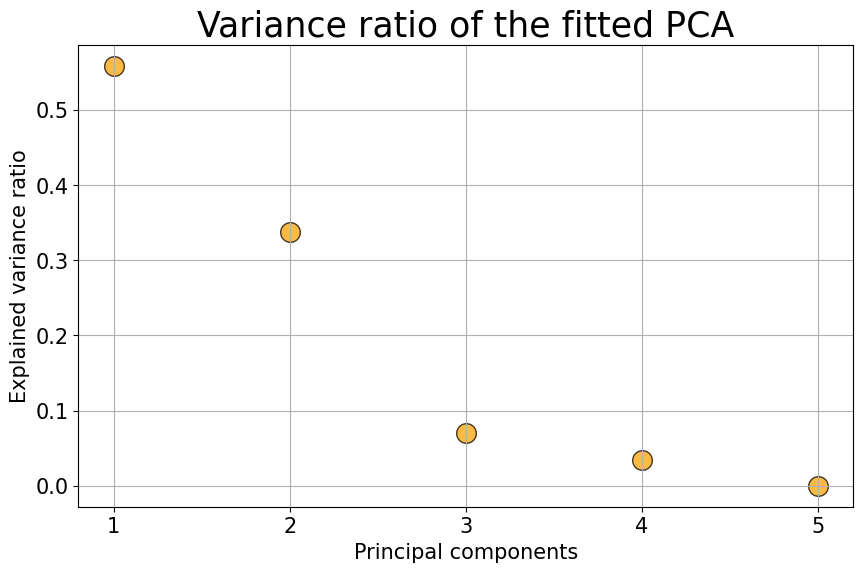

In [153]:
pca = PCA(n_components=None)
dfx_pca = pca.fit(dfx)
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],
            y=dfx_pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Variance ratio of the fitted PCA",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [199]:
var = pca.explained_variance_ratio_ 
var 

array([5.58465795e-01, 3.37362097e-01, 7.06271820e-02, 3.35449269e-02,
       7.57179119e-30])

In [200]:

# Cumulative variance 
var1 = np.cumsum(np.round(var, 4)*100)
var1 

array([ 55.85,  89.59,  96.65, 100.  , 100.  ])

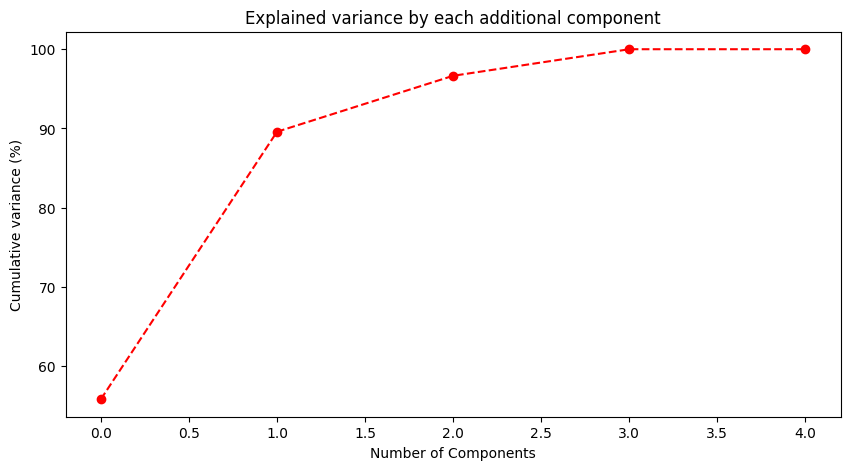

In [201]:
# Commulative Variance plot 
plt.figure(figsize=(10,5))
plt.plot(var1,color="red", linestyle='--', marker='o') 

plt.xlabel('Number of Components')
plt.title('Explained variance by each additional component')
plt.ylabel('Cumulative variance (%)')
plt.show()

In [154]:
dfx_trans = pca.transform(dfx)


In [155]:
dfx_trans = pd.DataFrame(data=dfx_trans)
dfx_trans.head(10)

,0,1,2,3,4
0,-0.299799,-0.556914,0.512511,0.187742,-1.059225e-15
1,-0.299799,-0.556914,0.512511,0.187742,-1.059225e-15
2,-0.299799,-0.556914,0.512511,0.187742,-1.059225e-15
3,-0.303606,-0.523119,-0.150773,0.129922,-1.253514e-15
4,-0.303606,-0.523119,-0.150773,0.129922,-1.253514e-15
5,-0.299799,-0.556914,0.512511,0.187742,-1.059225e-15
6,-0.299799,-0.556914,0.512511,0.187742,-1.059225e-15
7,-0.299799,-0.556914,0.512511,0.187742,-1.059225e-15
8,1.091784,-0.262544,-0.132542,-0.018793,3.881267e-15
9,-0.299799,-0.556914,0.512511,0.187742,-1.059225e-15


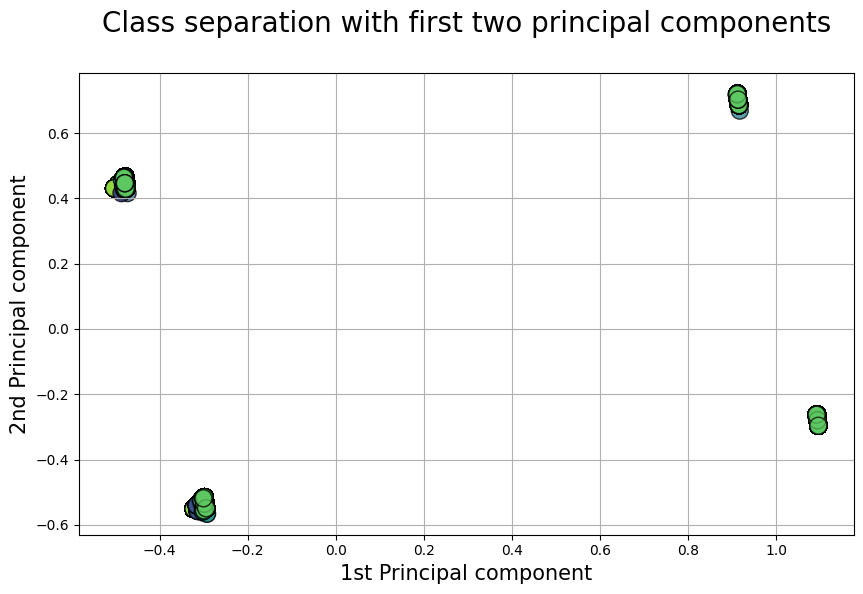

In [158]:
plt.figure(figsize=(10,6))
plt.scatter(dfx_trans[0],dfx_trans[1],c=temp['AnonRegion'],edgecolors='k',alpha=0.75,s=150)
plt.grid(True)
plt.title("Class separation with first two principal components\n",fontsize=20)
plt.xlabel("1st Principal component",fontsize=15)
plt.ylabel("2nd Principal component",fontsize=15)
plt.show()

In [181]:
data_for_cluster =dfx_trans[[0,1]]
data_for_cluster[0].values

array([-0.29979887, -0.29979887, -0.29979887, ...,  1.09368747,
        1.09178382,  1.09559112])

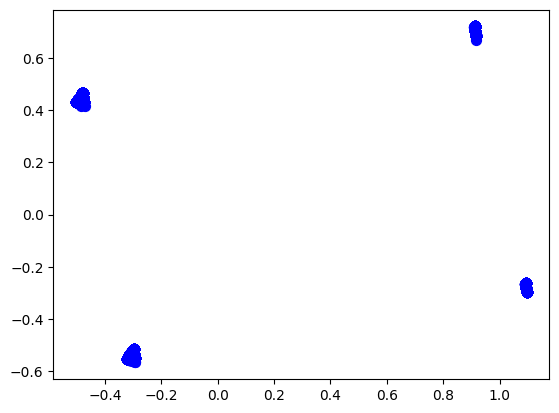

In [182]:
plt.scatter(data_for_cluster[0].values, data_for_cluster[1].values, s=50,color='blue');

In [184]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_for_cluster)
y_kmeans = kmeans.predict(data_for_cluster)

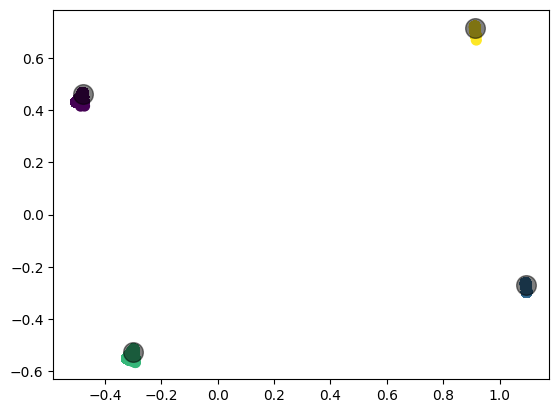

In [185]:
plt.scatter(data_for_cluster[0].values, data_for_cluster[1].values, c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [186]:
kmeans.cluster_centers_

array([[-0.47899221,  0.46083574],
       [ 1.0924545 , -0.26791095],
       [-0.29930175, -0.5254495 ],
       [ 0.91231535,  0.71305521]])

In [187]:
kmeans.inertia_

3.727138868528005

In [188]:
labels = kmeans.labels_

# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

Result: 1420 out of 21956 samples were correctly labeled.


In [189]:
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))


Accuracy score: 0.06


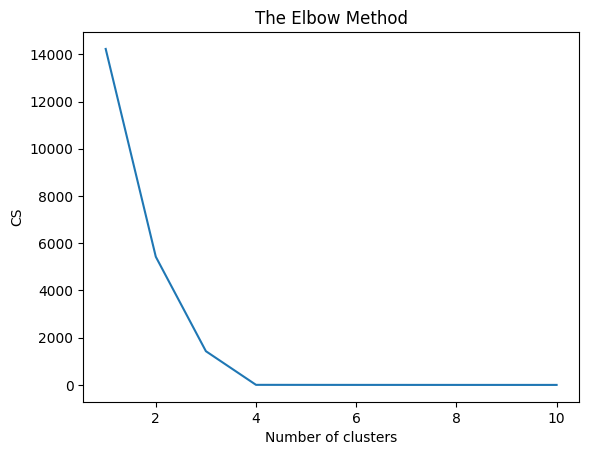

In [190]:
from sklearn.cluster import KMeans
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(data_for_cluster)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [212]:
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree


In [215]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(data_for_cluster)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(data_for_cluster, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.6824092792628532
For n_clusters=3, the silhouette score is 0.897818763592894
For n_clusters=4, the silhouette score is 0.9881259969169602
For n_clusters=5, the silhouette score is 0.905044076234232
For n_clusters=6, the silhouette score is 0.8597254130182883
For n_clusters=7, the silhouette score is 0.8422905231861629
For n_clusters=8, the silhouette score is 0.8283980238992616


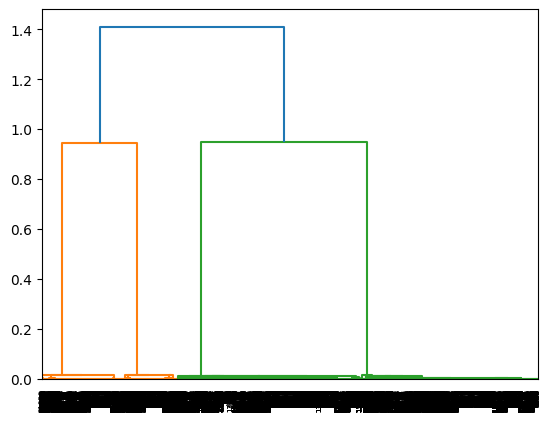

In [219]:
import sys
sys.setrecursionlimit(10000)

sl_mergings = linkage(data_for_cluster, method="single", metric='euclidean')
dendrogram(sl_mergings)
plt.show()

In [220]:
# 4 clusters using single linkge
sl_cluster_labels = cut_tree(sl_mergings, n_clusters=4).reshape(-1, )
sl_cluster_labels

array([0, 0, 0, ..., 1, 1, 1])

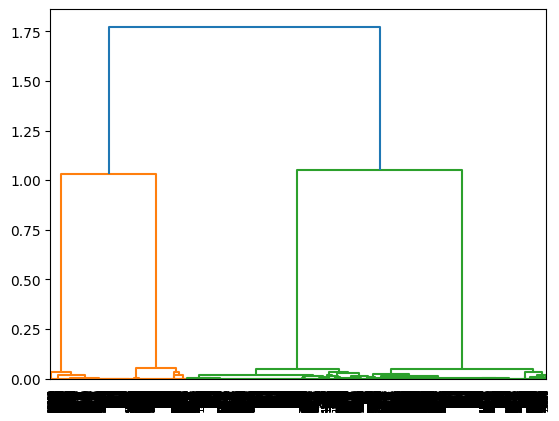

In [222]:
# complete linkage
cl_mergings = linkage(data_for_cluster, method="complete", metric='euclidean')
dendrogram(cl_mergings)
plt.show()

In [223]:
# 4 clusters using single linkge
sl_cluster_labels = cut_tree(sl_mergings, n_clusters=4).reshape(-1, )
sl_cluster_labels

array([0, 0, 0, ..., 1, 1, 1])

In [224]:
# 4 clusters using complete linkage
cl_cluster_labels = cut_tree(cl_mergings, n_clusters=4).reshape(-1, )
cl_cluster_labels

array([0, 0, 0, ..., 1, 1, 1])

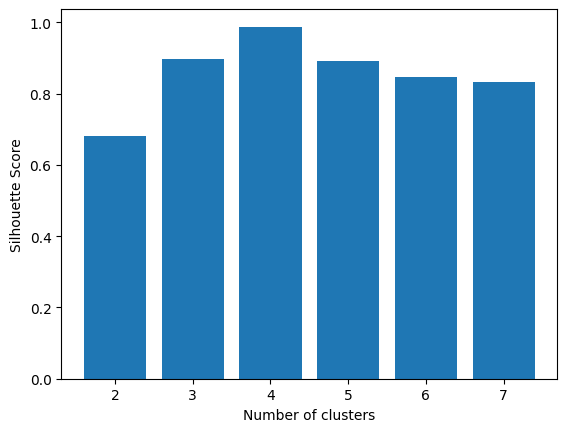

In [232]:
silhouette_scores = [] 

for n_cluster in range(2, 8):
    silhouette_scores.append( 
        silhouette_score(data_for_cluster, AgglomerativeClustering(n_clusters = n_cluster).fit_predict(data_for_cluster))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6,7] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

In [233]:
silhouette_score.

<function sklearn.metrics.cluster._unsupervised.silhouette_score(X, labels, *, metric='euclidean', sample_size=None, random_state=None, **kwds)>

In [227]:
agg = AgglomerativeClustering(n_clusters=4)
agg.fit(data_for_cluster)

AgglomerativeClustering(n_clusters=4)

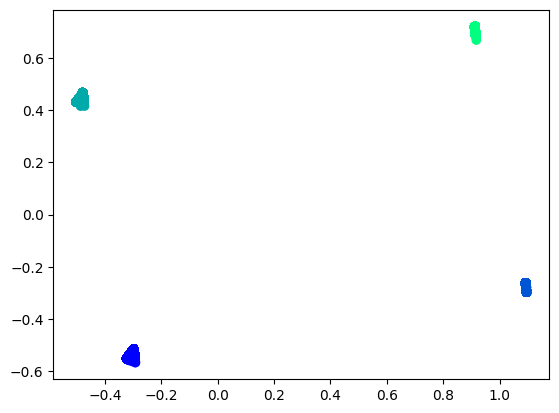

In [231]:
# Visualizing the clustering 
plt.scatter(data_for_cluster[0].values, data_for_cluster[1].values,  
           c = AgglomerativeClustering(n_clusters = 4).fit_predict(data_for_cluster), cmap =plt.cm.winter) 
plt.show() 

In [234]:
from sklearn.mixture import GaussianMixture

# Load the data
X = data_for_cluster

# Create a GaussianMixture object with 2 components
gmm = GaussianMixture(n_components=2)

# Fit the model to the data
gmm.fit(X)

# Predict the clusters for each data point
clusters = gmm.predict(X)
clusters

array([0, 0, 0, ..., 0, 0, 0])

In [244]:
# Import the necessary libraries
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_mutual_info_score

# Load the data
X = data_for_cluster
true_labels = temp['AnonRegion']
result = {}
for l in range(1,10):

    # Create a GaussianMixture object with 2 components
    gmm = GaussianMixture(n_components=l)

    # Fit the model to the data
    gmm.fit(X)

    # Predict the clusters for each data point
    predicted_clusters = gmm.predict(X)

    # Calculate the AMI score
    ami = adjusted_mutual_info_score(true_labels, predicted_clusters)
#     result.append(ami)
    result[l] = ami

result

{1: 0.0,
 2: 0.20082025488063976,
 3: 0.2088069643579807,
 4: 0.2188113094989146,
 5: 0.27195087091583564,
 6: 0.2955901396171534,
 7: 0.3093649359131331,
 8: 0.30325819232403506,
 9: 0.31005833209401046}

In [245]:
data_for_cluster

,0,1
0,-0.299799,-0.556914
1,-0.299799,-0.556914
2,-0.299799,-0.556914
3,-0.303606,-0.523119
4,-0.303606,-0.523119
...,...,...
21951,1.093687,-0.279442
21952,0.913421,0.702387
21953,1.093687,-0.279442
21954,1.091784,-0.262544
